### Задание
Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).  
Определить наиболее значимые переменные которые влияют на выживаемость.   
Визуализировать дерево решений.  
Написать вывод.  
Не копировать бездумно чужие работы.  


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 

### Анализ
Подготовим данные для построения модели и визуализируем дерево, с помощью которого постараемся проанализировать данные.

### Имплементация
Загрузим таблицу и посмотрим на столбцы

In [30]:
import pandas as pd

titanic_df = pd.read_csv('./titanic.csv')

print(titanic_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


- Заполним пропущенные данные т.к. данных не очень много и их не желательно удалять
- Преобразуем строковые столбцы как категориальные переменные
- Создадим новый признак: размер семьи
- Удалим столбцы которые не влияют на выживаемость (имя, ид записи и тп)
- Сбалансируем выборку выживших с использованием RandomOverSampler

In [31]:
from imblearn.over_sampling import RandomOverSampler

# Обработка пропущенных значений
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('Unknown')

# Кодирование категориальных переменных
titanic_df = pd.get_dummies(titanic_df, columns=['Sex', 'Embarked', 'Cabin'], drop_first=True)

# Создание признака "размер семьи"
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

# Удаление ненужных столбцов
titanic_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], inplace=True)

# Разделение данных на признаки и целевую переменную
X = titanic_df.drop(columns=['Survived'])
y = titanic_df['Survived']

print(X.head())

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X, y)

   Pclass   Age     Fare  Sex_male  Embarked_Q  Embarked_S  Cabin_A14  \
0       3  22.0   7.2500      True       False        True      False   
1       1  38.0  71.2833     False       False       False      False   
2       3  26.0   7.9250     False       False        True      False   
3       1  35.0  53.1000     False       False        True      False   
4       3  35.0   8.0500      True       False        True      False   

   Cabin_A16  Cabin_A19  Cabin_A20  ...  Cabin_F G63  Cabin_F G73  Cabin_F2  \
0      False      False      False  ...        False        False     False   
1      False      False      False  ...        False        False     False   
2      False      False      False  ...        False        False     False   
3      False      False      False  ...        False        False     False   
4      False      False      False  ...        False        False     False   

   Cabin_F33  Cabin_F38  Cabin_F4  Cabin_G6  Cabin_T  Cabin_Unknown  \
0      False   

Построим дерево решений. Ограничим максимальную глубину дерева до 3. Этим мы постараемся получить относительно абстрагированное и интерпретируемое дерево, которое будет легче анализировать и понимать.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

# Обучение модели
model = DecisionTreeClassifier(random_state=0, max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

Выведем метрики модели

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')

Accuracy: 0.78
Precision: 0.74
Recall: 0.85
F1-score: 0.79
ROC-AUC: 0.86


Для дерева с глубиной 3 метрики получились относительно хорошими, что означает, что модели можно доверять и визуализацию можно попытаться интерпретировать

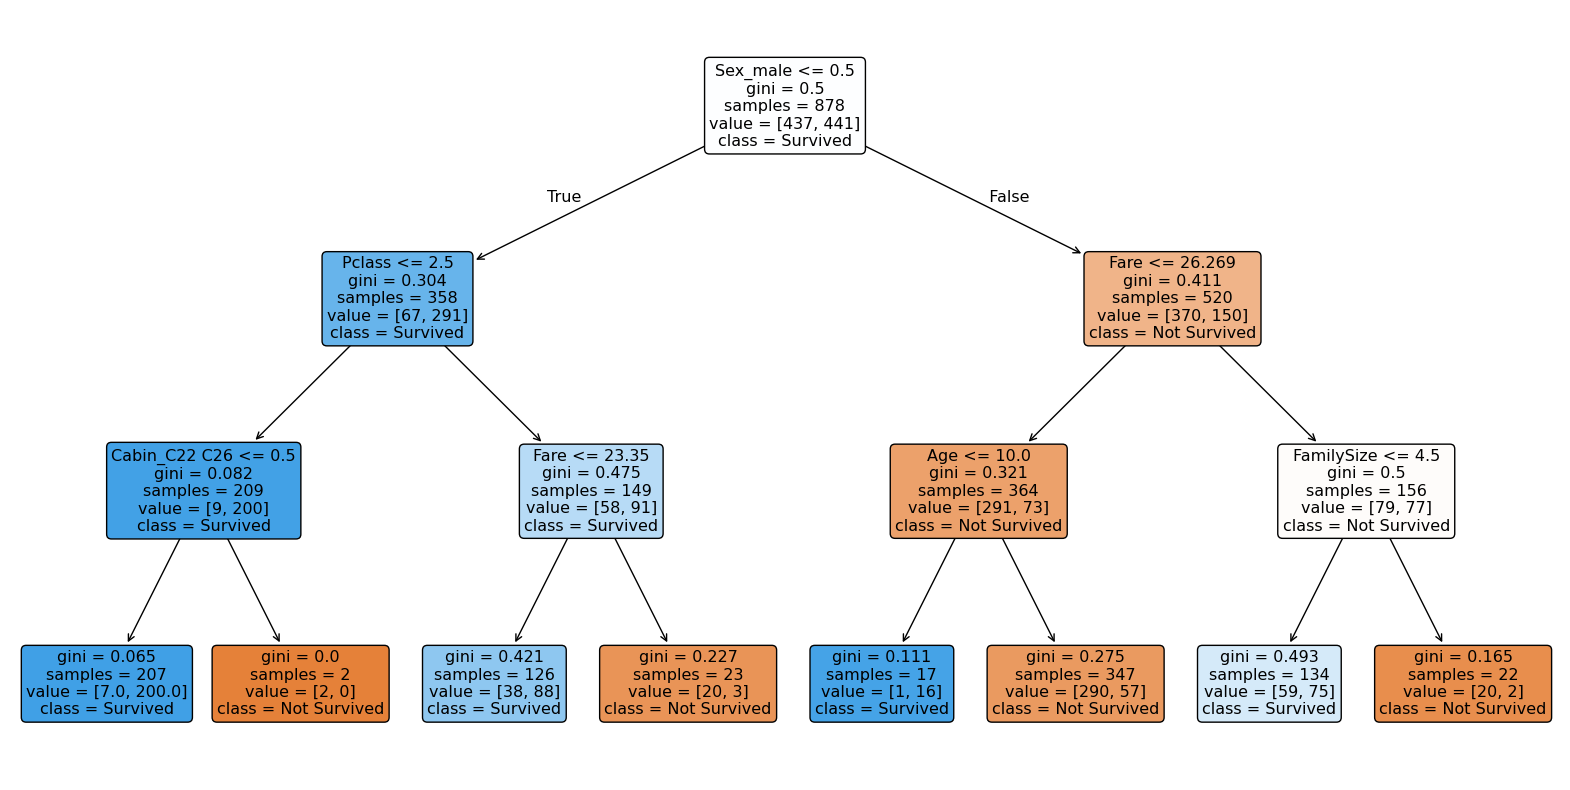

In [34]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

%matplotlib inline

plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X.columns, class_names=['Not Survived', 'Survived'], rounded=True)
plt.show()


### Выводы

- Наиболее значимые признаки по мере уменьшения значимости: пол, класс пассажира (тариф, палуба, класс), возраст и размер семьи.
- Мужчин выжило больше, чем женщин.
- Возраст влиял только для женского пола с дешевым проездом. Вероятность выжить у маленькой девочки (10 лет и младше) гораздо выше.
- Размер семьи влиял для женского пола с дорогим проездом. Вероятность выжить при семье, состоящей из 4 и менее человек, гораздо выше.
- Зависимость выживаемости от палубы напрямую оценить очень сложно, однако есть явная зависимость выживаемости от стоимости проезда и класса пассажира. Для мужчин оказалось выгоднее купить дешевые билеты в 3 классе. Для женщин выгоднее было купить более дорогие билеты.
- Построили интерпретируемую модель дерева решений с достаточно хорошими метриками.
